In [1]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)
import os
from openpyxl import Workbook
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bglogUKC import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretraining import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv6 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')
def update_tracker(file_name, data):
    if os.path.exists(file_name):
        wb = load_workbook(file_name)
    else:
        wb = Workbook()    
    wb.save(file_name)
    # wb.close(file_name)
    orig_df = pd.read_excel(file_name,)
    #print(orig_df.head())
    new_df = pd.DataFrame(data, )
    concat_df = pd.concat([orig_df, new_df], axis=0)
    #print(concat_df.head())
    concat_df.to_excel(file_name)
    return concat_df

def oset_train(ablation=5000,designated_ukc_cls=3,num_classes=2,embedding_size=128,lr_rate=3,optimizer='sgd',
pretrain_epochs=3,octrain_epochs=500,wait_patient=3, debug=False, tracker='tracker.xlsx', comment='',
             tracker_update=True):
    tf.random.set_seed(1234)
    np.random.seed(1234) 
    bglog = BGLog(save_padded_num_sequences=False, debug=debug,  load_from_pkl=True, )
    train_test = bglog.get_tensor_train_val_test(ablation=ablation, designated_ukc_cls=designated_ukc_cls )
    train_data, val_data, test_data = train_test
    line_encoder = LogLineEncoder(bglog, chars_in_line=64)
    logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
    ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
    ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)    
    pre_tr_acc = hist.history.get('accuracy')[len(hist.history.get('accuracy'))-1]
    # print(round(pre_tr_acc, 4))
    pre_val_acc = hist.history.get('val_accuracy')[len(hist.history.get('val_accuracy'))-1]
    # print(round(pre_val_acc, 4))
    oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
    _, _ = oset.train(train_data,data_val=val_data, epochs=octrain_epochs, 
                      lr_rate=lr_rate, wait_patient=wait_patient, optimizer=optimizer,
                     pretrain_hist=hist)
    _, _, f1_weighted, f_measure = oset.evaluate(test_data, ukc_label=designated_ukc_cls)
    lst = list(tf.reshape(oset.radius, (1, num_classes)).numpy()[0])
    lst = [str(i) for i in lst]
    radius = ','.join(lst)    
    loss = oset.losses[len(oset.losses)-1].numpy()    
    tracker_data = {'ablation':[ablation],'designated_ukc_cls': [designated_ukc_cls],'num_classes': [num_classes],
                   'embedding_size': [embedding_size], 'lr_rate': [lr_rate], 'optimizer': [optimizer],
                    'pretrain_epochs': [pretrain_epochs],'octrain_epochs': [oset.epoch], 'wait_patient': [wait_patient], 
                   'f1_weighted': [f1_weighted], 'f1_macro': f_measure.get('F1-score'), 
                   'F1Known': f_measure.get('Known'), 'F1Open': f_measure.get('Open'), 'loss':[loss], 'Radius': radius,
                   'pre_tr_acc': pre_tr_acc, 'pre_val_acc': pre_val_acc,'comment': comment}
    
    if tracker_update:
        update_tracker(tracker, tracker_data)
    return test_data, oset, hist

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 1400
val_0:, 175
test_0:, 175
train_1:, 1400
val_1:, 175
test_1:, 175
train_2:, 1400
val_2:, 175
test_2:, 175
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/6
131/131 [==============================] - 14s 99ms/step - loss: 0.0876 - accuracy: 0.9699 - precision: 0.9820 - recall: 0.9501 - val_loss: 0.0092 - val_accuracy: 0.9980 - val_precision: 0.9980 - val_recall: 0.9980
Epoch 2/6
131/131 [==============================] - 13s 96ms/step - loss: 0.0076 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - val_loss: 0.0754 - val_accuracy: 0.9805 - val_precision: 0.9805 - val_recall: 0.9805
Epoch 3/6
131/131 [==============================] - 13s 98ms/step - loss: 0.0065 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - val_loss: 0.2007 - val_accuracy: 0.9609 - val_precision

100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.35it/s]


epoch: 1/500, train_loss: 2.9428586959838867, F1_train: 0.5979459279978232 F1_val: 0.5643184267241379


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.36it/s]


epoch: 2/500, train_loss: 2.942420721054077, F1_train: 0.6284068631657141 F1_val: 0.6252409699675324


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.36it/s]


epoch: 3/500, train_loss: 2.9470293521881104, F1_train: 0.8619635781430546 F1_val: 0.9747710987261147


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.39it/s]


epoch: 4/500, train_loss: 2.9456048011779785, F1_train: 0.8765207806286937 F1_val: 0.9747936320754718


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.36it/s]


epoch: 5/500, train_loss: 2.9440159797668457, F1_train: 0.8935211426247509 F1_val: 0.9748263888888888


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.36it/s]


epoch: 6/500, train_loss: 2.9424235820770264, F1_train: 0.9045999691386085 F1_val: 0.9759196218652038


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.35it/s]


epoch: 7/500, train_loss: 2.9441606998443604, F1_train: 0.9104048574364546 F1_val: 0.9748263888888888


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.35it/s]


epoch: 8/500, train_loss: 2.940661668777466, F1_train: 0.9164337978775823 F1_val: 0.9758885782747604


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.32it/s]


epoch: 9/500, train_loss: 2.9436728954315186, F1_train: 0.9211910913665494 F1_val: 0.9759094045741326


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:18<00:00,  7.07it/s]


epoch: 10/500, train_loss: 2.942361354827881, F1_train: 0.9241387790048434 F1_val: 0.9747936320754718


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:18<00:00,  7.21it/s]


epoch: 11/500, train_loss: 2.9461026191711426, F1_train: 0.9269406189000597 F1_val: 0.9748046875


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.32it/s]


epoch: 12/500, train_loss: 2.9458718299865723, F1_train: 0.9290984534259128 F1_val: 0.9747710987261147


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.35it/s]


epoch: 13/500, train_loss: 2.944265365600586, F1_train: 0.9308258916479328 F1_val: 0.977029284591195


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:18<00:00,  7.22it/s]


epoch: 14/500, train_loss: 2.9466140270233154, F1_train: 0.9330210829013725 F1_val: 0.978125


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.31it/s]


epoch: 15/500, train_loss: 2.938807725906372, F1_train: 0.934216000469824 F1_val: 0.9792325949367089


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.32it/s]


epoch: 16/500, train_loss: 2.945967435836792, F1_train: 0.9362563539584627 F1_val: 0.9748156055900621


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.35it/s]


epoch: 17/500, train_loss: 2.9460408687591553, F1_train: 0.9397542310122674 F1_val: 0.9747936320754718


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.34it/s]


epoch: 18/500, train_loss: 2.9440197944641113, F1_train: 0.9446505698723354 F1_val: 0.9747936320754718


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.34it/s]


epoch: 19/500, train_loss: 2.9441161155700684, F1_train: 0.9525614952632507 F1_val: 0.9758885782747604


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.35it/s]


epoch: 20/500, train_loss: 2.9415745735168457, F1_train: 0.9598590022837851 F1_val: 0.9748046875


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.33it/s]


epoch: 21/500, train_loss: 2.9435174465179443, F1_train: 0.9642739309940793 F1_val: 0.9748156055900621


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.35it/s]


epoch: 22/500, train_loss: 2.9432575702667236, F1_train: 0.9685855578800673 F1_val: 0.9747596153846154


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.33it/s]


epoch: 23/500, train_loss: 2.9462759494781494, F1_train: 0.9715409081537479 F1_val: 0.9748156055900621


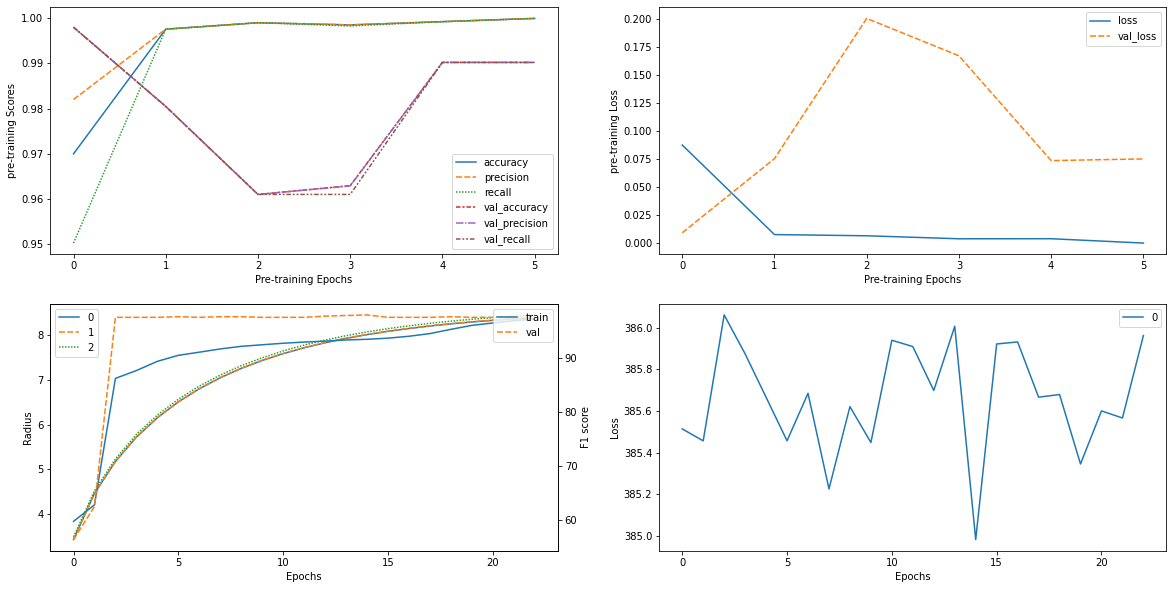

[[172   0   0   0]
 [  0 170   0   0]
 [  0   0 169   3]
 [  0   9   0 149]]
98.21
f1_weighted: 0.9821230957322555, f1_macro: 0.9816761757514137, f1_micro: 0.9821428571428571, f_measure: {'Known': 98.8471, 'Open': 96.129, 'F1-score': 98.1676}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       0.95      1.00      0.97       170
           2       1.00      0.98      0.99       172
           5       0.98      0.94      0.96       158

    accuracy                           0.98       672
   macro avg       0.98      0.98      0.98       672
weighted avg       0.98      0.98      0.98       672



In [2]:
comment=" beyond 12 it is not improving.Lets Reduce it and increase data"
test_data, oset, hist = oset_train(ablation=1750,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=6, wait_patient=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 1600
val_0:, 200
test_0:, 200
train_1:, 1600
val_1:, 200
test_1:, 200
train_2:, 1600
val_2:, 200
test_2:, 200
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/6
150/150 [==============================] - 15s 99ms/step - loss: 0.0781 - accuracy: 0.9690 - precision_1: 0.9866 - recall_1: 0.9542 - val_loss: 0.0038 - val_accuracy: 0.9983 - val_precision_1: 0.9983 - val_recall_1: 0.9983
Epoch 2/6
150/150 [==============================] - 15s 97ms/step - loss: 0.0040 - accuracy: 0.9994 - precision_1: 0.9994 - recall_1: 0.9994 - val_loss: 5.5647e-05 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/6
150/150 [==============================] - 15s 98ms/step - loss: 8.9033e-05 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 1.9042e-05 - val_

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.23it/s]


epoch: 1/500, train_loss: 2.268678903579712, F1_train: 0.6530201112386874 F1_val: 0.6600666517724159


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.24it/s]


epoch: 2/500, train_loss: 2.2687132358551025, F1_train: 0.6823587089513561 F1_val: 0.6683936881908087


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.23it/s]


epoch: 3/500, train_loss: 2.2687556743621826, F1_train: 0.9216065071781723 F1_val: 0.9991297014068332


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:21<00:00,  7.10it/s]


epoch: 4/500, train_loss: 2.268674850463867, F1_train: 0.9256516649078882 F1_val: 0.9991297014068332


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:21<00:00,  7.10it/s]


epoch: 5/500, train_loss: 2.2686469554901123, F1_train: 0.9295977310853804 F1_val: 0.9991296779808528


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.20it/s]


epoch: 6/500, train_loss: 2.2688095569610596, F1_train: 0.9401824662995211 F1_val: 0.9991296779808528


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:21<00:00,  7.11it/s]


epoch: 7/500, train_loss: 2.268781900405884, F1_train: 0.9427842242960982 F1_val: 0.9991296540603929


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.21it/s]


epoch: 8/500, train_loss: 2.268683671951294, F1_train: 0.9504217488176262 F1_val: 0.9991297014068332


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.18it/s]


epoch: 9/500, train_loss: 2.268732786178589, F1_train: 0.9617971921707378 F1_val: 0.9991296779808528


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.22it/s]


epoch: 10/500, train_loss: 2.268770694732666, F1_train: 0.9835330247534826 F1_val: 0.9991297243535094


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.23it/s]


epoch: 11/500, train_loss: 2.2687084674835205, F1_train: 0.984882405894804 F1_val: 0.9991296540603929


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.21it/s]


epoch: 12/500, train_loss: 2.268784284591675, F1_train: 0.985223151945504 F1_val: 0.9991296540603929


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:21<00:00,  6.90it/s]


epoch: 13/500, train_loss: 2.268630266189575, F1_train: 0.9854499457641251 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:21<00:00,  7.02it/s]


epoch: 14/500, train_loss: 2.2685964107513428, F1_train: 0.9856764440859141 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.18it/s]


epoch: 15/500, train_loss: 2.2686822414398193, F1_train: 0.9857895826159123 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.18it/s]


epoch: 16/500, train_loss: 2.268829584121704, F1_train: 0.9859026474880134 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.15it/s]


epoch: 17/500, train_loss: 2.2687342166900635, F1_train: 0.9859026474880134 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.18it/s]


epoch: 18/500, train_loss: 2.268745183944702, F1_train: 0.9860156387741253 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.17it/s]


epoch: 19/500, train_loss: 2.2686259746551514, F1_train: 0.9860156387741253 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.19it/s]


epoch: 20/500, train_loss: 2.2688331604003906, F1_train: 0.9861199031682975 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.17it/s]


epoch: 21/500, train_loss: 2.268840789794922, F1_train: 0.9861199031682975 F1_val: 1.0


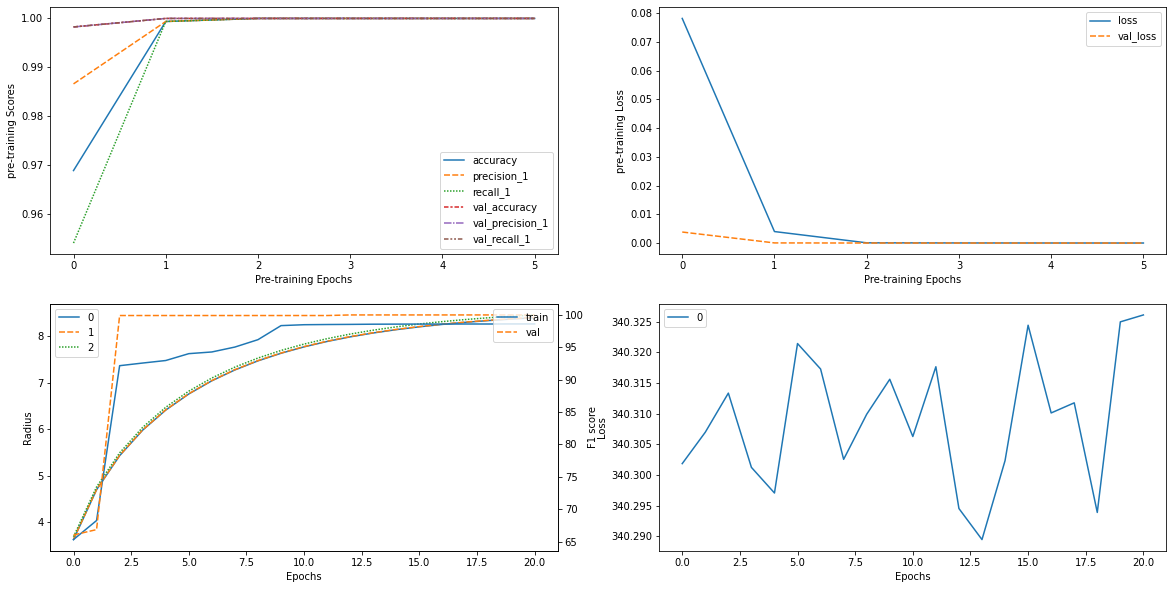

[[197   0   0   0]
 [  0 192   0   0]
 [  0   0 186   0]
 [  3   2   0 156]]
99.32
f1_weighted: 0.9931753861183268, f1_macro: 0.992872276781077, f1_micro: 0.9932065217391305, f_measure: {'Known': 99.5754, 'Open': 98.4227, 'F1-score': 99.2872}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       197
           1       0.99      1.00      0.99       192
           2       1.00      1.00      1.00       186
           5       1.00      0.97      0.98       161

    accuracy                           0.99       736
   macro avg       0.99      0.99      0.99       736
weighted avg       0.99      0.99      0.99       736



In [3]:
b

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2000
val_0:, 250
test_0:, 250
train_1:, 2000
val_1:, 250
test_1:, 250
train_2:, 2000
val_2:, 250
test_2:, 250
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/6
187/187 [==============================] - 18s 96ms/step - loss: 0.0672 - accuracy: 0.9793 - precision_2: 0.9882 - recall_2: 0.9662 - val_loss: 8.5805e-04 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 2/6
187/187 [==============================] - 18s 95ms/step - loss: 0.0021 - accuracy: 0.9992 - precision_2: 0.9993 - recall_2: 0.9992 - val_loss: 2.3739e-05 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 3/6
187/187 [==============================] - 18s 96ms/step - loss: 5.0672e-05 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - val_loss: 1.1871e-05 - 

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.22it/s]


epoch: 1/500, train_loss: 2.7133829593658447, F1_train: 0.6429361007454664 F1_val: 0.6739130434782609


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.25it/s]


epoch: 2/500, train_loss: 2.7121026515960693, F1_train: 0.934016462337945 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.28it/s]


epoch: 3/500, train_loss: 2.7084109783172607, F1_train: 0.9376485578123753 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.29it/s]


epoch: 4/500, train_loss: 2.714592218399048, F1_train: 0.9384131678103466 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.25it/s]


epoch: 5/500, train_loss: 2.7129995822906494, F1_train: 0.9392645836920088 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.30it/s]


epoch: 6/500, train_loss: 2.7126104831695557, F1_train: 0.9402627018703865 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.26it/s]


epoch: 7/500, train_loss: 2.710394859313965, F1_train: 0.9414303968633098 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.00it/s]


epoch: 8/500, train_loss: 2.712339162826538, F1_train: 0.9427691376231657 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.07it/s]


epoch: 9/500, train_loss: 2.713240385055542, F1_train: 0.943686992021216 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.22it/s]


epoch: 10/500, train_loss: 2.707228660583496, F1_train: 0.949070261225878 F1_val: 1.0


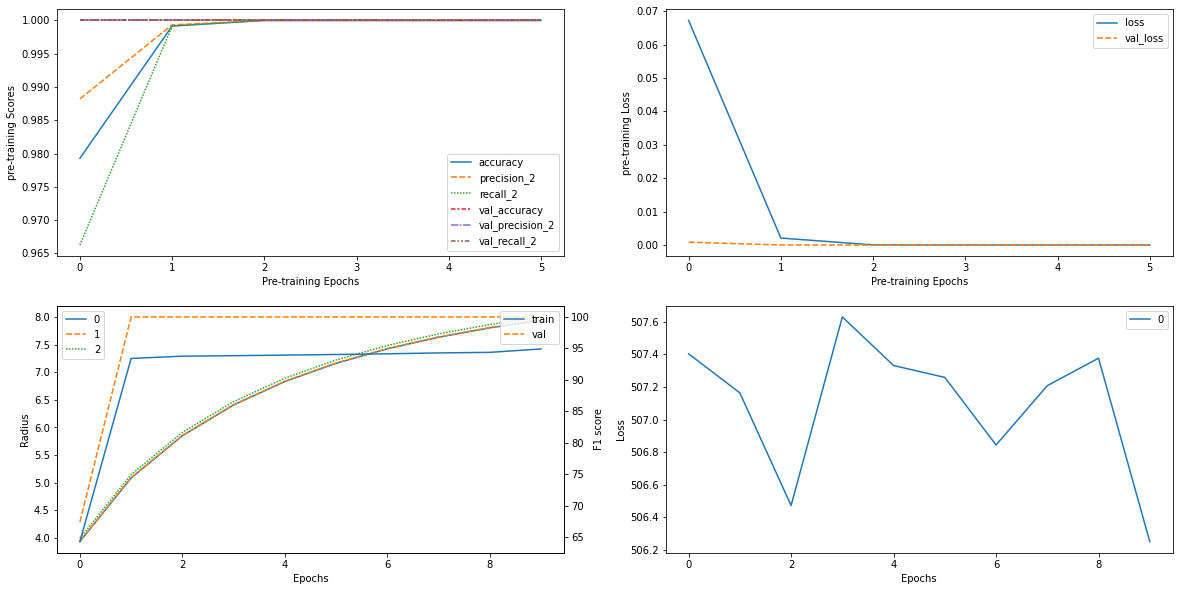

[[243   0   0   0]
 [  0 233   0  13]
 [  0   0 236   9]
 [  0   0   0 162]]
97.54
f1_weighted: 0.9759361754411993, f1_macro: 0.97264132288026, f1_micro: 0.9754464285714286, f_measure: {'Known': 98.4716, 'Open': 93.6416, 'F1-score': 97.2641}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      0.95      0.97       246
           2       1.00      0.96      0.98       245
           5       0.88      1.00      0.94       162

    accuracy                           0.98       896
   macro avg       0.97      0.98      0.97       896
weighted avg       0.98      0.98      0.98       896



In [4]:
comment="better score achived with 2000 data, lets increase data"
test_data, oset, hist = oset_train(ablation=2500,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=6, wait_patient=8, comment=comment)